## $$
\partial_t u + u \partial_x u = \nu \partial^{2}_{xx} u
$$

- $u\partial_x u$: convective term
- $\nu \partial_{xx}^{2}u$: diffusive term

In [63]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("bmh")

# TVD : Total Variation Diminishing (Harten, 1983) 

In [64]:
Nx= 200
#cfl= 0.2
tmax = 1 # time 0 ~ 1

#viscosity_coeff = (0.01/np.pi)
viscosity_coeff = 0.02

x = np.linspace(-1,1, 200)

#t = 0  , I.C
u = -1*np.sin(np.pi * x)
dx = abs(x[1]-x[0])

dt = 0.002# cfl * dx / np.max(np.abs(u))

nt = int(tmax/ dt) #+ 1

uf = np.zeros((nt,Nx))
uf[0, :] = u

print(nt)
print(dt)
print(nt * dt, tmax )

500
0.002
1.0 1


In [65]:
def f(u):
    y = 0.5 * u**2
    yp = u
    return y, yp

In [66]:
def minmod(a,b):
    return 0.5 * (np.sign(a)+ np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [67]:
def RHS(u, dx, viscosity_coeff):
    #diffusion term
    diffusion_term = viscosity_coeff * (np.roll(u,1)- 2*u + np.roll(u,-1))/ dx**2
    
    ux = minmod((u - np.roll(u,1))/dx ,  (np.roll(u,-1) - u)/dx)
    
    uL = np.roll(u -0.5 * dx*ux,1)
    uR = u -0.5 * dx*ux
    fL,fpL = f(uL)
    fR,fpR = f(uR)
    a = np.maximum(np.abs(fpL), np.abs(fpR))
    
    H =0.5 * (fL + fR - a * (uR - uL))
    
    conv_term  = -(np.roll(H,-1)-H)/dx
    
    y = conv_term + diffusion_term
    return y

In [68]:
for i in range(1, nt):
    u1 = u + dt * RHS(u,dx,viscosity_coeff)
    u = 0.5 * u + 0.5 * (u1 + dt * RHS(u1, dx,viscosity_coeff))
    uf[i, :] = u

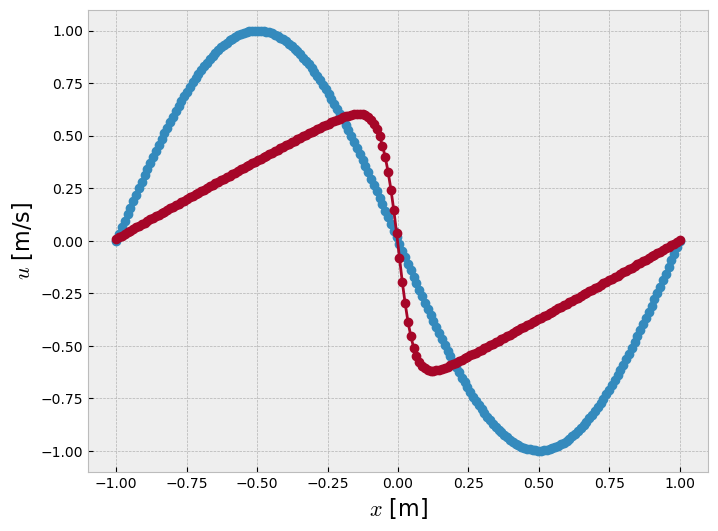

In [69]:
plt.figure(figsize=(8,6));
plt.plot(x, uf[0], '-o', label="Initial Wave");
plt.plot(x, uf[-1], '-o', label="Final Wave");
plt.xlabel(r'$x$ [m]', fontsize=16);
plt.ylabel(r"$u$ [m/s]", fontsize=16);

# Inverse Physics-Informed Neural Networks (I-PINNs)

## Preparing training data

In [70]:
uf # all u from num.sim.
tf = np.linspace(0, 1, nt) # t 
xf = x # x

In [71]:
tf_tensor = torch.tensor(tf)
xf_tensor = torch.tensor(xf)
print(len(tf_tensor))
print(len(xf_tensor))

500
200


In [72]:
combined_tensor_x_train = torch.empty((len(tf)*len(xf), 2), dtype=torch.float32)

In [73]:
index = 0
for i in range(len(tf)):
    for j in range(len(xf)):
        combined_tensor_x_train[index][0] = xf_tensor[j]
        combined_tensor_x_train[index][1] = tf_tensor[i]
        index+=1

In [74]:
print(len(combined_tensor_x_train))

100000


In [75]:
combined_tensor_x_train

tensor([[-1.0000,  0.0000],
        [-0.9899,  0.0000],
        [-0.9799,  0.0000],
        ...,
        [ 0.9799,  1.0000],
        [ 0.9899,  1.0000],
        [ 1.0000,  1.0000]])

In [76]:
y_train = torch.tensor(uf, dtype=torch.float32) # from tvd
y_train = y_train.view(-1)
y_train = y_train.unsqueeze(1)

In [77]:
y_train

tensor([[ 1.2246e-16],
        [ 3.1569e-02],
        [ 6.3106e-02],
        ...,
        [-1.4358e-02],
        [-6.6555e-03],
        [ 1.0607e-03]])

In [78]:
len(y_train)

100000

## Define Neural Nets

In [79]:
nu = 2.0
print("The real value: ", viscosity_coeff, " Our inital guess: ", nu)

The real value:  0.02  Our inital guess:  2.0


In [80]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,30),
            torch.nn.Tanh(),
            torch.nn.Linear(30,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,1),
            torch.nn.Tanh(),
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

In [81]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        
        
        self.nu = torch.tensor([nu], requires_grad=True).float().to(device)
        
        self.nu = torch.nn.Parameter(self.nu)
        
        self.model = NN().to(device)
        
        self.model.register_parameter('nu', self.nu)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        #################### Input the data #################
        self.X_train = combined_tensor_x_train
        self.y_train = y_train
        #####################################################
        
        self.X = self.X.to(device)
        self.X.requires_grad = True
        
        self.X_train= self.X_train.to(device)
        self.y_train= self.y_train.to(device)
        
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
        self.criterion = torch.nn.MSELoss()
        
        self.iter = 1
        
    def loss_func(self):
        self.adam.zero_grad()
        
        #####################
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        #####################
        
        
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]
        
        
        nu_pde  = self.nu
        
        loss_pde = self.criterion(du_dt+ 1 * u.squeeze()*du_dx, nu_pde* du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print("iteration number =",self.iter, " loss value =", loss.item(), "real nu=",viscosity_coeff,"I-PINNs nu=", self.nu.item())
        
        self.iter= self.iter + 1
        
        return loss
    
    def train(self):
        self.model.train()
        
        for i in range(10000):
            self.adam.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [82]:
net = Net()
net.train()
net.model.eval()

iteration number = 100  loss value = 0.19862765073776245 real nu= 0.02 I-PINNs nu= 1.9141827821731567
iteration number = 200  loss value = 0.17588470876216888 real nu= 0.02 I-PINNs nu= 1.8642244338989258
iteration number = 300  loss value = 0.16324341297149658 real nu= 0.02 I-PINNs nu= 1.7959882020950317
iteration number = 400  loss value = 0.16017717123031616 real nu= 0.02 I-PINNs nu= 1.6973905563354492
iteration number = 500  loss value = 0.1578644961118698 real nu= 0.02 I-PINNs nu= 1.5864418745040894
iteration number = 600  loss value = 0.15545527637004852 real nu= 0.02 I-PINNs nu= 1.4668972492218018
iteration number = 700  loss value = 0.15277725458145142 real nu= 0.02 I-PINNs nu= 1.3436627388000488
iteration number = 800  loss value = 0.14996282756328583 real nu= 0.02 I-PINNs nu= 1.2114999294281006
iteration number = 900  loss value = 0.14670239388942719 real nu= 0.02 I-PINNs nu= 1.0696965456008911
iteration number = 1000  loss value = 0.14171196520328522 real nu= 0.02 I-PINNs nu=

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
    (9): Tanh()
  )
)

In [83]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [84]:
y_pred_ipinns = y_pred

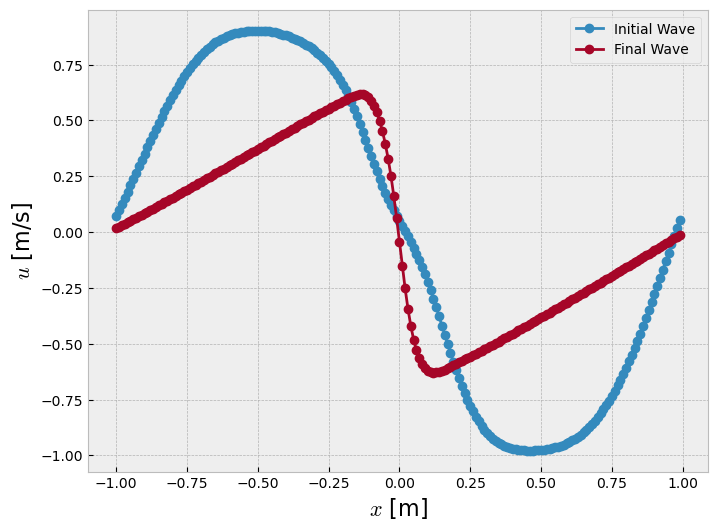

In [89]:
plt.figure(figsize=(8,6));
plt.plot(x, y_pred_ipinns[:, 0], '-o', label="Initial Wave");
plt.plot(x, y_pred_ipinns[:, -1], '-o', label="Final Wave");
plt.xlabel(r'$x$ [m]', fontsize=16);
plt.ylabel(r"$u$ [m/s]", fontsize=16);
plt.legend();

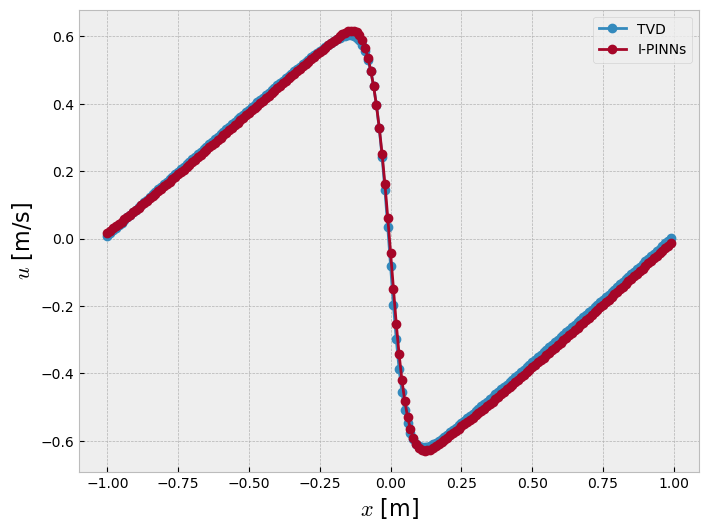

In [90]:
plt.figure(figsize=(8,6));
plt.plot(x, uf[-1], '-o', label="TVD");
plt.plot(x, y_pred_ipinns[:, -1], '-o', label="I-PINNs");
plt.xlabel(r'$x$ [m]', fontsize=16);
plt.ylabel(r"$u$ [m/s]", fontsize=16);
plt.legend();

In [91]:
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred_ipinns, cmap='jet')

<Axes: >

## Comparison with PINNs

In [93]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,30),
            torch.nn.Tanh(),
            torch.nn.Linear(30,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,1),
            torch.nn.Tanh(),
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        
        
        self.lambda_value = torch.tensor([nu], requires_grad=True).float().to(device)
        
        self.lambda_value = nn.Parameter(self.nu)
        
        self.model = NN().to(device)
        
        self.model.register_parameter('nu', self.nu)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        #################### Input the data #################
        self.X_train = combined_tensor_x_train
        self.y_train = y_train
        #####################################################
        
        self.X = self.X.to(device)
        self.X.requires_grad = True
        
        self.X_train= self.X_train.to(device)
        self.y_train= self.y_train.to(device)
        
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
        self.criterion = torch.nn.MSELoss()
        
        self.iter = 1
        
    def loss_func(self):
        self.adam.zero_grad()
        
        #####################
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        #####################
        
        
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]
        
        
        nu_pde  = self.nu
        
        loss_pde = self.criterion(du_dt+ 1 * u.squeeze()*du_dx, nu* du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print("iteration number =",self.iter, " loss value =", loss.item(), "real mu=",viscosity_coeff,"IPINN lambda=", self.nu.item())
        
        self.iter= self.iter + 1
        
        return loss
    
    def train(self):
        self.model.train()
        
        for i in range(5000):
            self.adam.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()